#The University of Pavia dataset consists of two files: PaviaU.mat and PaviaU_gt.mat.

---



---


PaviaU.mat contains the hyperspectral data of the University of Pavia. This file contains the actual hyperspectral image data captured by the Reflective Optics System Imaging Spectrometer (ROSIS) sensor. The data in this file is stored in a matrix format, where each pixel in the image corresponds to a particular spectral signature, or a set of values for each of the 115 bands.

---


PaviaU_gt.mat contains the ground truth data for the University of Pavia hyperspectral image. The ground truth data is used to evaluate the performance of the hyperspectral image classification models. This file contains the labeled data for each pixel in the hyperspectral image, with each pixel labeled as one of the 9 different classes. The ground truth data is also stored in a matrix format, where each pixel corresponds to a particular class label.

---



---


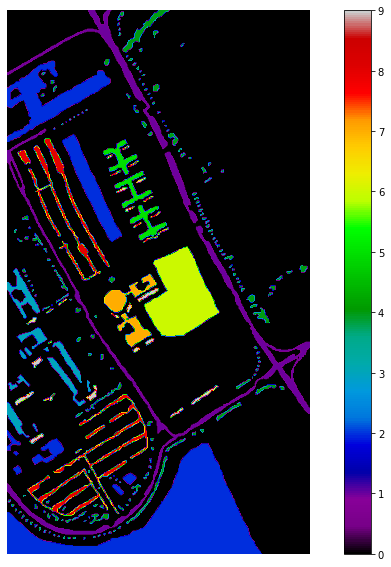

# Libraries 

In [1]:
pip install --upgrade keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
Note: you may

In [2]:
import scipy.io as sio
import numpy as np
from scipy.io import loadmat
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Conv1D, Activation, MaxPooling1D, Dense, Flatten, Reshape
import pandas as pd
from keras.layers.convolutional import Conv1D,Conv3D
import keras
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, Activation, Add, Multiply, Concatenate, Flatten
from keras.layers import BatchNormalization, Embedding, Conv2D, MaxPooling2D, GlobalAveragePooling2D,MaxPooling3D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.regularizers import l1, l2


# Read Dataset

In [3]:
data = loadmat('/kaggle/input/pavia-university-hsi/PaviaU.mat')['paviaU']

gt = loadmat('/kaggle/input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

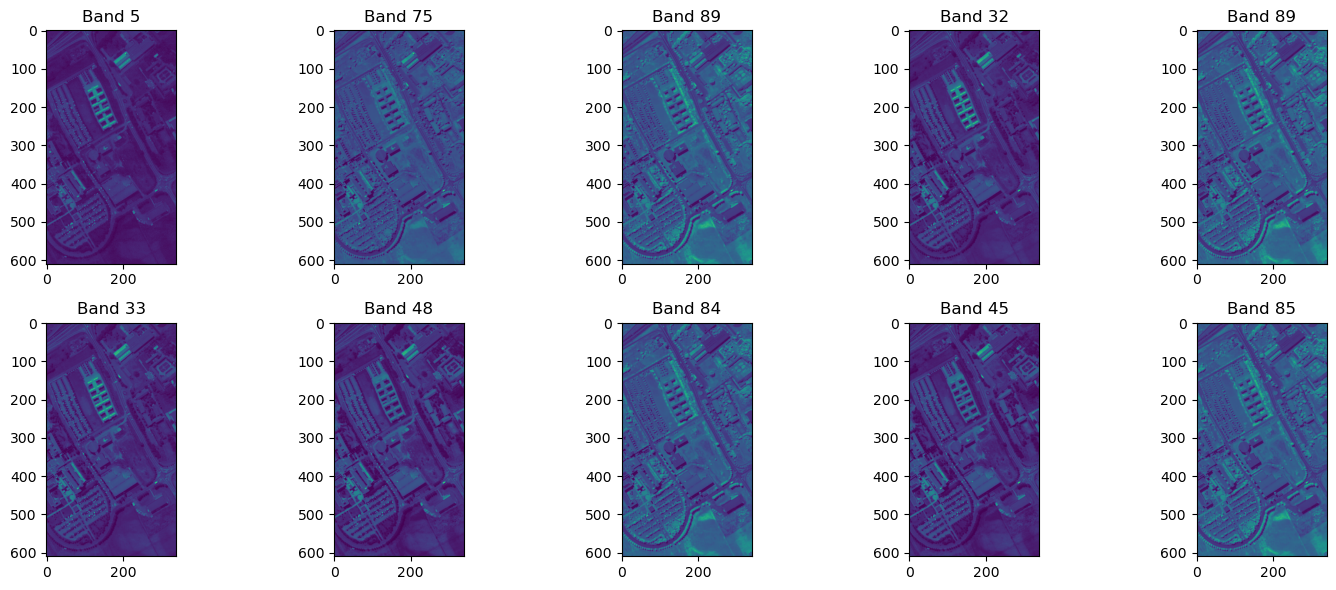

In [4]:
z = data.reshape(data.shape[0]*data.shape[1], -1)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

for i, band in enumerate(np.random.choice(103, 10)):
    axs[i].imshow(z[:, band].reshape(data.shape[0], data.shape[1]))
    axs[i].set_title(f"Band {band}")

plt.tight_layout()
plt.show()

In [5]:
X = df[df['class']!=0].iloc[:, :-1].values
import numpy as np
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
# Normalize the data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 


In [6]:
print(X_norm.shape)

(42776, 103)


In [7]:
print(y.shape)

(42776, 10)


In [8]:

import numpy as np

def etr(images, num_dimensions=50):
    """
    Applies the ETR algorithm to a set of normalized hyperspectral images.

    Args:
        images (ndarray): 2D numpy array with shape (num_images, num_bands).
        num_dimensions (int): Number of dimensions to reduce the data to.

    Returns:
        ndarray: 2D numpy array with shape (num_images, num_dimensions).
    """
    # Compute the covariance matrix of the images
    cov = np.cov(images.T)

    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)

    # Sort the eigenvalues in descending order
    sort_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sort_indices]
    eigvecs = eigvecs[:, sort_indices]

    # Select the top num_dimensions eigenvectors
    V = eigvecs[:, :num_dimensions]

    # Project the images onto the selected eigenvectors
    embeddings = np.dot(images, V)

    return embeddings

# Apply the ETR algorithm to reduce the dimensions to 50
X_emb = etr(X_norm)

# Check the shape of the embeddings
print(X_emb.shape)  # should be (num_images, 50)


(42776, 50)


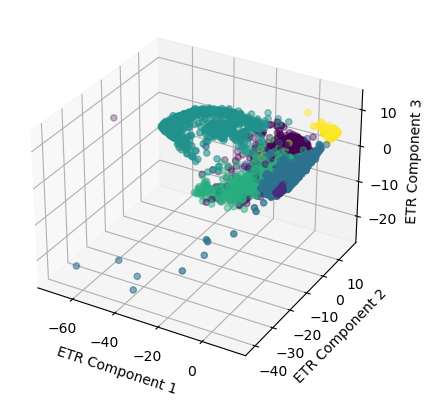

In [9]:
# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_emb[:, 0], X_emb[:, 1], X_emb[:, 2], c=y.argmax(axis=1))
ax.set_xlabel('ETR Component 1')
ax.set_ylabel('ETR Component 2')
ax.set_zlabel('ETR Component 3')
plt.show()

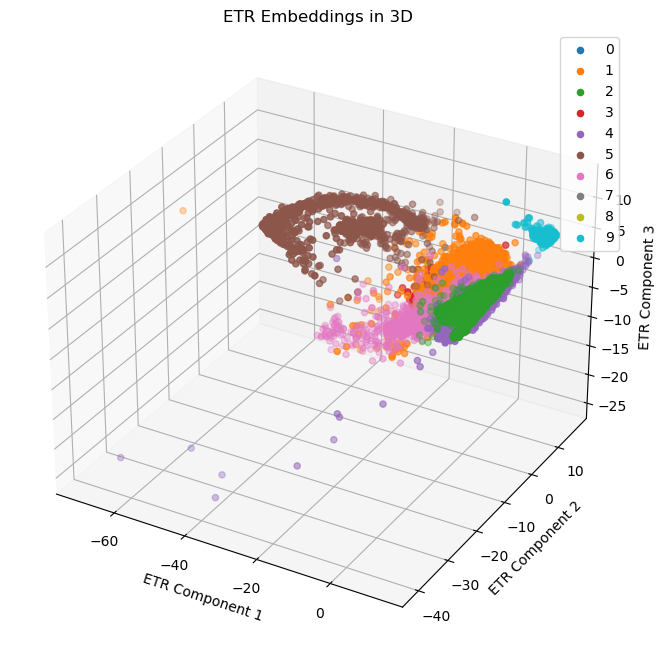

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a color map for the class labels
cmap = plt.cm.get_cmap('tab10')
# Plot the embeddings in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(y.shape[1]):
    ax.scatter(X_emb[y[:, i] == 1, 0], X_emb[y[:, i] == 1, 1], X_emb[y[:, i] == 1, 2], c=cmap(i), label=i)
ax.set_xlabel('ETR Component 1')
ax.set_ylabel('ETR Component 2')
ax.set_zlabel('ETR Component 3')
ax.set_title('ETR Embeddings in 3D')
ax.legend()
plt.show()

In [11]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2,stratify=y, random_state=42)

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34220, 50) (8556, 50) (34220, 10) (8556, 10)


In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34220, 50) (8556, 50) (34220, 10) (8556, 10)


# MODEL


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import BatchNormalization, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


In [15]:
input_shape = (50, 1, 1, 1)
num_nodes = 50


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv3D, BatchNormalization, Activation, MaxPooling3D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class GATLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, feature_dim):
        super(GATLayer, self).__init__()
        self.num_heads = num_heads
        self.feature_dim = feature_dim
        self.W = [self.add_weight(name='W_{}'.format(i),
                                   shape=(feature_dim, feature_dim),
                                   initializer='glorot_uniform',
                                   trainable=True) for i in range(num_heads)]
        self.a = [self.add_weight(name='a_{}'.format(i),
                                   shape=(2*feature_dim, 1),
                                   initializer='glorot_uniform',
                                   trainable=True) for i in range(num_heads)]
        self.dropout = Dropout(0.3)
        self.activation = Activation('relu')

    def call(self, inputs):
        outputs = []
        for i in range(self.num_heads):
            h = tf.matmul(inputs, self.W[i])
            a = tf.concat([h, h], axis=-1)
            e = self.activation(tf.matmul(a, self.a[i]))
            alpha = tf.nn.softmax(e, axis=1)
            alpha = self.dropout(alpha)
            output = tf.reduce_sum(tf.multiply(h, alpha), axis=1)
            outputs.append(output)
        return tf.concat(outputs, axis=-1)


num_nodes = 50
input_layer = Input(shape=(50,1))
dense_layer = Dense(32, activation='relu')(input_layer)
gat_layer = GATLayer(num_heads=4, feature_dim=32)(dense_layer)
print(gat_layer.shape)
reshape_layer = Reshape((16, 4, 2))(gat_layer) # modify shape argument
print(reshape_layer.shape)
conv_layer1 = Conv3D(256, kernel_size=(3, 3, 1), padding='same')(tf.expand_dims(reshape_layer, axis=-1))
batchnorm_layer1 = BatchNormalization()(conv_layer1)
activation_layer1 = Activation('relu')(batchnorm_layer1)
conv_layer2 = Conv3D(128, kernel_size=(3, 3, 1), padding='same')(activation_layer1)
batchnorm_layer2 = BatchNormalization()(conv_layer2)
activation_layer2 = Activation('relu')(batchnorm_layer2)
pooling_layer1 = MaxPooling3D(pool_size=(2, 2, 1))(activation_layer2)
conv_layer5 = Conv3D(64, kernel_size=(3, 3, 1), padding='same')(pooling_layer1)
batchnorm_layer5 = BatchNormalization()(conv_layer5)
activation_layer5 = Activation('relu')(batchnorm_layer5)

flatten_layer = Flatten()(activation_layer5)
dense_layer1 = Dense(32)(flatten_layer)
batchnorm_layer7 = BatchNormalization()(dense_layer1)
activation_layer7 = Activation('relu')(batchnorm_layer7)
dropout_layer1 = Dropout(0.1)(activation_layer7)
dense_layer2 = Dense(16)(dropout_layer1)
batchnorm_layer8 = BatchNormalization()(dense_layer2)
activation_layer8 = Activation('relu')(batchnorm_layer8)
output_layer = Dense(10, activation='sigmoid')(activation_layer8)
# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with the modified architecture
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


(None, 128)
(None, 16, 4, 2)


In [17]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 dense (Dense)               (None, 50, 32)            64        
                                                                 
 gat_layer (GATLayer)        (None, 128)               4352      
                                                                 
 reshape (Reshape)           (None, 16, 4, 2)          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 16, 4, 2, 1)      0         
                                                                 
 conv3d (Conv3D)             (None, 16, 4, 2, 256)     2560      
                                                                 
 batch_normalization (BatchN  (None, 16, 4, 2, 256)    1024  

In [18]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

In [19]:
history=model.fit(X_train.reshape(X_train.shape ), y_train,
          batch_size=32,
          epochs=700,
          validation_data=(X_test.reshape(X_test.shape ), y_test),
          verbose=1, callbacks=[es])

Epoch 1/700
1070/1070 [==============================] - 24s 11ms/step - loss: 1.2627 - accuracy: 0.5456 - val_loss: 1.1146 - val_accuracy: 0.5624
Epoch 2/700
1070/1070 [==============================] - 11s 10ms/step - loss: 0.9332 - accuracy: 0.6323 - val_loss: 1.7172 - val_accuracy: 0.5162
Epoch 3/700
1070/1070 [==============================] - 11s 10ms/step - loss: 0.8433 - accuracy: 0.6688 - val_loss: 1.1168 - val_accuracy: 0.5880
Epoch 4/700
1070/1070 [==============================] - 11s 11ms/step - loss: 0.7942 - accuracy: 0.6853 - val_loss: 1.0732 - val_accuracy: 0.6027
Epoch 5/700
1070/1070 [==============================] - 11s 10ms/step - loss: 0.7711 - accuracy: 0.6932 - val_loss: 0.9905 - val_accuracy: 0.6093
Epoch 6/700
1070/1070 [==============================] - 11s 10ms/step - loss: 0.7495 - accuracy: 0.7019 - val_loss: 0.8771 - val_accuracy: 0.6667
Epoch 7/700
1070/1070 [==============================] - 12s 11ms/step - loss: 0.7459 - accuracy: 0.7017 - val_loss: 0

In [20]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)


268/268 [==============================] - 1s 5ms/step - loss: 0.6427 - accuracy: 0.7399
Loss: 0.6426688432693481
Accuracy: 0.739948570728302


In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred=model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

268/268 [==============================] - 1s 3ms/step


In [22]:
test_labels = np.argmax(y_test, axis=1)

In [23]:
print(test_labels)
print(y_pred)

[6 2 1 ... 3 6 6]
[1 2 2 ... 8 6 6]


In [24]:
score=accuracy_score(test_labels, y_pred)*100
print('Accuracy : \n{0}'.format(score))
from sklearn.metrics import confusion_matrix,classification_report
conf_mx = confusion_matrix(test_labels, y_pred)
print('Confusion matrix of testing: \n{0}'.format(conf_mx))
print(classification_report(test_labels, y_pred))


Accuracy : 
73.99485741000468
Confusion matrix of testing: 
[[ 963  213   31    7    1   11   19   81    0]
 [ 142 3251    6  218    0   73    0   40    0]
 [  33   20   51    4    0    0    0  312    0]
 [  74   25    0  510    1    2    0    1    0]
 [   3    1    0   49  215    1    0    0    0]
 [  15  550   14    4    1  384    0   38    0]
 [ 162    7    5    0    0    0   87    5    0]
 [  12   19   11    2    0    9    0  684    0]
 [   0    0    0    3    0    0    0    0  186]]
              precision    recall  f1-score   support

           1       0.69      0.73      0.71      1326
           2       0.80      0.87      0.83      3730
           3       0.43      0.12      0.19       420
           4       0.64      0.83      0.72       613
           5       0.99      0.80      0.88       269
           6       0.80      0.38      0.52      1006
           7       0.82      0.33      0.47       266
           8       0.59      0.93      0.72       737
           9       1

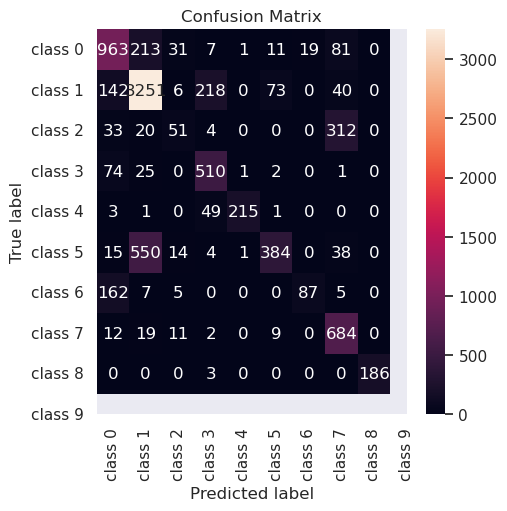

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix using the matplotlib library
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d',
xticklabels=['class 0', 'class 1', 'class 2', 'class 3','class 4', 'class 5', 'class 6', 'class 7','class 8', 'class 9'],
yticklabels=['class 0', 'class 1', 'class 2', 'class 3','class 4', 'class 5', 'class 6', 'class 7','class 8', 'class 9'], ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


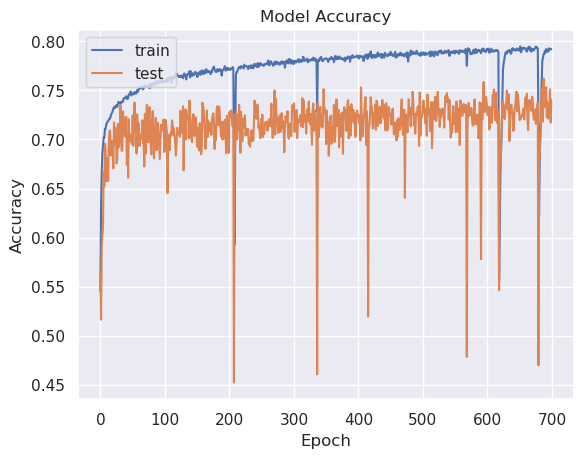

In [26]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

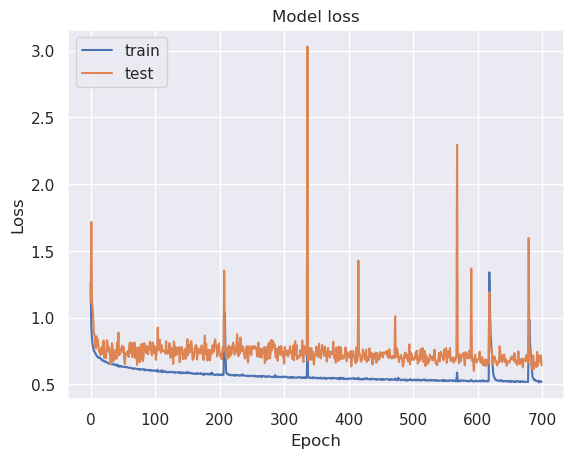

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

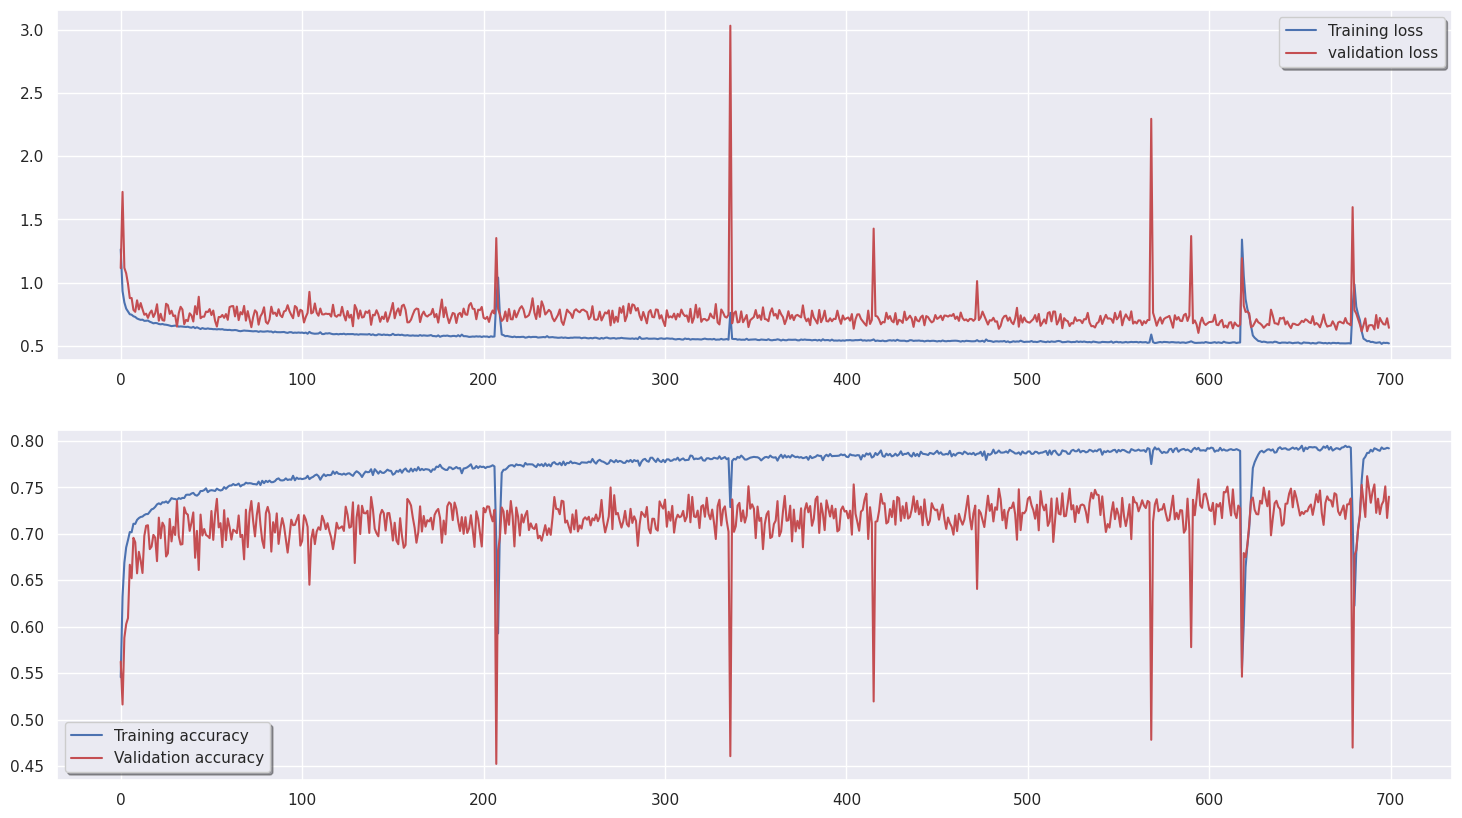

In [28]:

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

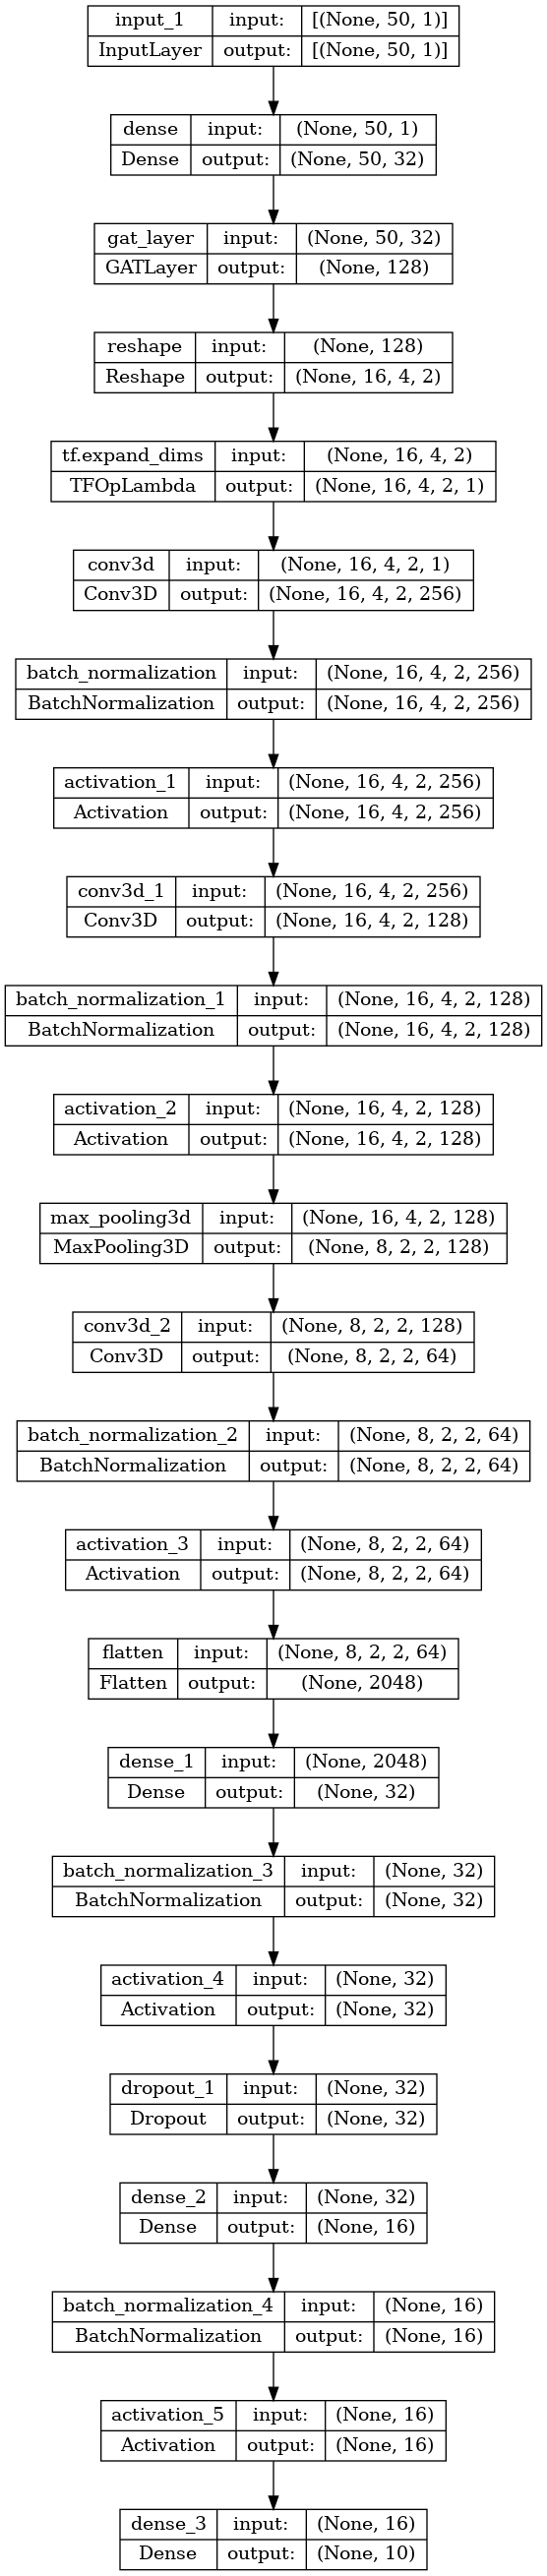

In [29]:

keras.utils.plot_model(model, './model_plot.png', show_shapes = True)
     

In [30]:
from sklearn.metrics import cohen_kappa_score
#calculate Cohen's Kappa
cohen_kappa_score(test_labels, y_pred)*100

64.8138782783573